# Bayesian Long Short-Term Memory Network Example
This example implements a bayesian version of LSTM (Hochreiter, Schmidhuber, 1997) using `tf.keras` and `edward2`.  
It's based on the discussion in this [issue](https://github.com/google/edward2/issues/474).  

This notebook is divided in the following sections:  
1. Data generation
2. Training a baseline LSTM
3. Training a bayesian LSTM
4. Conclusion

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import edward2 as ed
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, ParameterGrid
from tensorflow.keras.preprocessing import sequence

import EmbeddedReberGrammar as erg

2022-03-11 15:18:28.203479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-11 15:18:28.203503: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_hist(hist):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['val_accuracy'], label='val_accuracy')
    plt.plot(hist.history['accuracy'], label='train_accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.plot(hist.history['loss'], label='train_loss')
    plt.legend()
    plt.show()

### Data generation
We generate random, valid and invalid strings from the embedded reber grammar as inputs. The objective is a binary classification between valid and invalid strings.

In [3]:
x, y = [], []
n = 3000
for i in range(n):
    x.append(np.asarray(erg.encode_string(erg.generate_valid_string(erg.embedded_rg))))
    y.append(1)
for i in range(n):
    x.append(np.asarray(erg.encode_string(erg.generate_invalid_string(erg.embedded_rg))))
    y.append(0)
x = sequence.pad_sequences(x)
x_train, x_test, y_train, y_test = train_test_split(np.asarray(x), np.asarray(y))

In [4]:
print(f"Number of training samples: {x_train.shape[0]}")
print(f"Number of test samples: {x_test.shape[0]} \n")

sequence_length = x_train.shape[1]
num_chars = x_train.shape[2]
print(f"Length of sequences: {sequence_length}")
print(f"Number of characters: {num_chars}")

Number of training samples: 4500
Number of test samples: 1500 

Length of sequences: 39
Number of characters: 8


#### Hyperparameters

In [5]:
batch_size = 64
epochs = 40

## Training a baseline LSTM
This is our baseline model. It's a simple RNN with a single layer of LSTM cells.  
As it would be expected the model cann quickly be fitted to differentiate the valid from the invalid strings.

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(sequence_length, num_chars)))
model.add(tf.keras.layers.RNN(
    tf.keras.layers.LSTMCell(128)
))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, 128)               70144     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 70,273


2022-03-11 15:18:30.742643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 15:18:30.743059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-11 15:18:30.743214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-11 15:18:30.743325: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-11 15:18:30.743429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Trainable params: 70,273
Non-trainable params: 0
_________________________________________________________________


In [7]:
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0)

In [8]:
test_results = model.evaluate(x_test, y_test)
print(f"Test loss: {test_results[0]}")
print(f"Test accuracy: {test_results[1]}")

47/47 [==============================] - 0s 8ms/step - loss: 0.0900 - accuracy: 0.9767
Test loss: 0.09001268446445465
Test accuracy: 0.9766666889190674


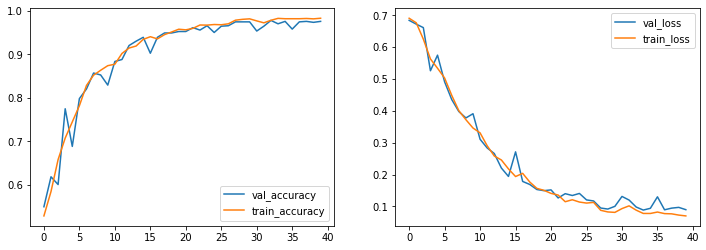

In [9]:
plot_hist(hist)

## Training a bayesian LSTM
In comparison we build a similar RNN we we replace the standard LSTM cells with the LSTMCellFlipout class from `edward2`.

In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(sequence_length, num_chars)))
model.add(tf.keras.layers.RNN(
    ed.layers.LSTMCellFlipout(128)
    ))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_1 (RNN)                 (None, 128)               139776    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 143,937
Trainable params: 143,937
Non-trainable params: 0
_________________________________________________________________


In [11]:
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=256, verbose=0)

From the training curves and the test results it's clear that the model is not converging and we are not able to differentiate the valid from the invalid strings.

In [12]:
test_results = model.evaluate(x_test, y_test)
print(f"Test loss: {test_results[0]}")
print(f"Test accuracy: {test_results[1]}")

47/47 [==============================] - 1s 13ms/step - loss: 135806.1719 - accuracy: 0.4780
Test loss: 135806.171875
Test accuracy: 0.4779999852180481


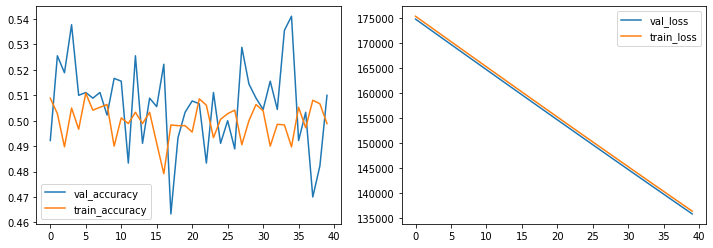

In [13]:
plot_hist(hist)

#### Hyperparameter tuning
In this section we run the experiments with different important parameters.

In [14]:
params = {
    'loss_scaling': [1., 1./x_train.shape[0]],
    'batch_size': [64, 128, 256],
    'clipvalue': [None, 0.1, 0.5],
}

param_grid = ParameterGrid(params)
results = pd.DataFrame(columns=list(params.keys())+['test_loss', 'test_accuracy'])

In [15]:
def training_run(param_set):
    sf = param_set['loss_scaling']
    bs = int(param_set['batch_size'])
    cv = param_set['clipvalue']

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(sequence_length, num_chars)))
    model.add(tf.keras.layers.RNN(
        ed.layers.LSTMCellFlipout(
            128, 
            kernel_regularizer=ed.regularizers.NormalKLDivergence(scale_factor=sf),
            recurrent_regularizer=ed.regularizers.NormalKLDivergence(scale_factor=sf)
            ),
        ))
    model.add(tf.keras.layers.Dense(32))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(clipvalue=cv)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    hist = model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=bs, verbose=0)
    return model, hist

In [16]:
for param_set in param_grid:
    model, hist = training_run(param_set)

    test_results = np.mean(np.asarray([model.evaluate(x_test, y_test, verbose=0) for _ in range(10)]), axis=0)
    new_line = param_set
    new_line['test_loss'] = test_results[0]
    new_line['test_accuracy'] = test_results[1]
    results = pd.concat([results, pd.DataFrame(new_line, index=[0])], ignore_index=True, axis=0)

#### Analysing the impact of hyperparameters

The followin plot shows the test accuracy over the hyperparameters. It's clear that scaling the loss of the bayesian layers in the model is necessary to reach convergence.

To plot those results NaN values in the `clipvalues` column are set to `-1`. In the corresponding runs gradients were not clipped.

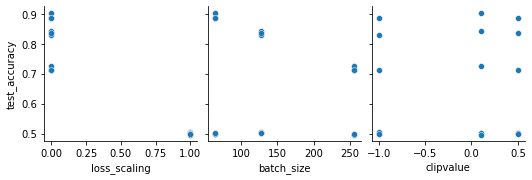

In [17]:
results_ = results.drop(columns=['test_loss']).fillna(-1)
sns.pairplot(results_, y_vars=['test_accuracy'], x_vars=['loss_scaling', 'batch_size', 'clipvalue'])

Choosing the correct batch size as well as possibly a value to clip gradients by during the training is more complicated.  
From those experiments it looks like a smaller batch size will be benefitial, even though this is also dependent on the dataset. Running this experiment with less samples shows that a larger batch size can greatly increase accuracy. A possible explaination for this behaviour is that in cases where less data is available, larger batch sizes compensate for the additional variance that is caused by the bayesian properties.

Using this dataset, clipping the values doesn't seem to have a huge affect on the outcome.

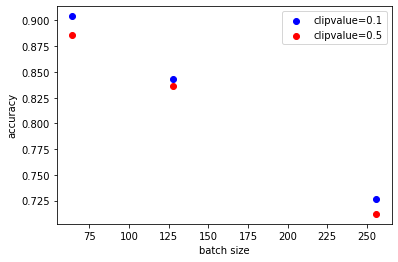

In [18]:
results_ = results_[results_['loss_scaling'] != 1.]
results_lowclip = results_[results_['clipvalue'] == 0.1].drop(columns=['loss_scaling'])
results_highclip = results_[results_['clipvalue'] == 0.5].drop(columns=['loss_scaling'])
plt.scatter(results_lowclip['batch_size'], results_lowclip['test_accuracy'], c='b', label="clipvalue=0.1")
plt.scatter(results_highclip['batch_size'], results_highclip['test_accuracy'], c='r', label="clipvalue=0.5")
plt.xlabel("batch size")
plt.ylabel("accuracy")
plt.legend()
plt.show()

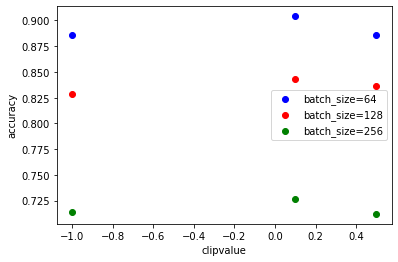

In [19]:
results_ = results_[results_['loss_scaling'] != 1.]
results_64 = results_[results_['batch_size'] == 64].drop(columns=['loss_scaling'])
results_128 = results_[results_['batch_size'] == 128].drop(columns=['loss_scaling'])
results_256 = results_[results_['batch_size'] == 256].drop(columns=['loss_scaling'])
plt.scatter(results_64['clipvalue'], results_64['test_accuracy'], c='b', label="batch_size=64")
plt.scatter(results_128['clipvalue'], results_128['test_accuracy'], c='r', label="batch_size=128")
plt.scatter(results_256['clipvalue'], results_256['test_accuracy'], c='g', label="batch_size=256")
plt.xlabel("clipvalue")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### Training the best bayesian Model

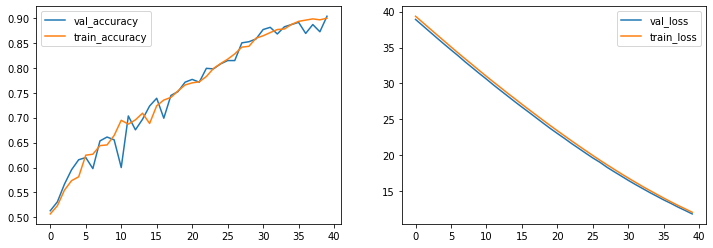

In [20]:
best_params = results_.iloc[np.argmax(results_['test_accuracy'])].to_dict()
if best_params['clipvalue'] < 0:
    best_params['clipvalue'] = None

model, hist = training_run(best_params)

plot_hist(hist)

### Conclusion
This example is supposed two highlight a few pitfalls that can occur when working with BNN and `edward2` for the first time. As seen from the results, especially scaling the loss values for any bayesian layers is important to achieve convergence!  
The second important change made here to switch from a standard LSTM to a bayesian LSTM is increasing the batch size. 
Gradient clipping can in many cases also be a helpfull technique to reach better results. Both batch size and gradient clipping are hyperparameters which need to be chosen carefully to achieve best results.